In [19]:
import aioredis
import graphitesend
import random
import orjson

In [3]:
pool=await aioredis.create_redis_pool("redis://localhost:55000")

In [61]:
async def rm_all():
    for k in await pool.keys("*"):
        await pool.delete(k)

In [59]:
client = graphitesend.GraphiteClient(
    prefix="anomaly_detection",
    graphite_server="localhost",
    system_name="",
    graphite_port=55010,
    autoreconnect=True,
)

In [102]:
import orjson
data=[orjson.loads(x)["job"] for x in await pool.zrevrangebyscore("application_1619449271907_0381")]

In [116]:
await pool.keys("*")

[b'application_1621434214720_2415',
 b'job_group:application_1621434214720_2415:job_group_0',
 b'applications',
 b'sequential_jobs:application_1621434214720_2415',
 b'job_group:application_1621434214720_2415:job_group_1']

In [119]:
for x in await pool.keys("tspj:*"):
    await pool.delete(x)
for x in await pool.keys("tspj:application_1621434214720_2415:anomaly_detection"):
    await pool.delete(x)
for x in await pool.keys("tspj:application_1621434214720_2415:feature_bypass"):
    await pool.delete(x)
for x in await pool.keys("ml:*"):
    await pool.delete(x)

In [100]:
max(int(i) for i in await pool.smembers('tspj:application_1621434214720_2415:feature_bypass'))

407

In [102]:
max(int(i) for i in await pool.smembers('tspj:application_1621434214720_2415:anomaly_detection'))

407

In [78]:
!ls /tmp/ml:application_1621434214720_2415:autoencoder:job_group_1.h5

/tmp/ml:application_1621434214720_2415:autoencoder:job_group_1.h5


In [62]:
await rm_all()

In [155]:
with open("../sample_data/job_list_sample", "wb") as f:
    f.write(data[0])

In [158]:
await pool.smembers(f"processed_jobs:1")

[]

In [35]:
await pool.zcount("sequential_jobs:application_1619800099011_0001")

2

In [186]:
import itertools

In [188]:
itertools.chain([1,2], [3,4])

[1, 2, 3, 4]

In [83]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt

In [95]:
x=(np.array([np.random.normal() for i in range(100)]+[2200]) + 1000).reshape(-1,1)

In [111]:
isf = IsolationForest(warm_start=True)
isf.fit(x)
isf.predict(x)

array([ 1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,
        1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])

In [121]:
isf.fit(np.array([1,1]).reshape(-1,1))

TypeError: fit() got an unexpected keyword argument 'n_estimators'

In [100]:
pred=isf.score_samples(x)

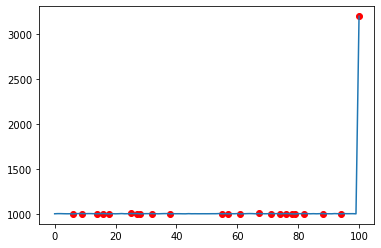

In [119]:
plt.plot(x)
data = [(idx, y) for idx, y in enumerate(x) if pred[idx] < -.58]
plt.scatter([x[0] for x in data], [x[1] for x in data], color="red")

In [124]:
!pip install tensorflow

     |████████████████████████████████| 173.9 MB 198 kB/s eta 0:00:01
     |████████████████████████████████| 129 kB 243 kB/s eta 0:00:01
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 3.3 MB 192 kB/s eta 0:00:01
  Using cached h5py-2.10.0-cp37-cp37m-macosx_10_6_intel.whl (3.0 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 15.6 MB 349 kB/s eta 0:00:01
     |████████████████████████████████| 65 kB 664 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 412 kB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 252 kB/s eta 0:00:01
     |████████████████████████████████| 146 kB 306 kB/s eta 0:00:01
     |████████████████████████████████| 97 kB 350 kB/s eta 0:00:01
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Usin

You should consider upgrading via the '/Users/p.ashikhmin/git/spark-luxmeter/venv/bin/python3.7 -m pip install --upgrade pip' command.


In [141]:
import keras
from keras import layers
import itertools

In [214]:
data_raw=open("../sample_data/grafana_metrics", "r").read()
data_json=orjson.loads(data_raw)

In [260]:
whole_data = np.array([x[0] for x in data_json[0]["datapoints"]])
timestamps = np.array([x[1] for x in data_json[0]["datapoints"]])

result = []
for i in range(len(whole_data)):
    if whole_data[i] == None:
        n_idx, next_value = next(((idx, x) for idx, x in enumerate(whole_data[i+1:], i+1) if x is not None), (None, None))
        p_idx_, prev_value = next(((idx, x) for idx, x in enumerate(reversed(whole_data[:i]), 1) if x is not None), (None, None))
        if prev_value is not None:
            p_idx = i - p_idx_
        if next_value is None or prev_value is None:
            whole_data[i] = next_value or prev_value
        else:
            dtn = timestamps[n_idx] - timestamps[i]
            dtp = timestamps[i] - timestamps[p_idx]
            dts = dtn + dtp
            dtn /= dts
            dtp /= dts
            assert 0.99 < dtn + dtp <= 1, dtn + dtp
            whole_data[i] = next_value * dtn + prev_value * dtp

whole_data = np.array([x for x in whole_data if x is not None])
            
training_mean = whole_data.mean()
training_std = whole_data.std()
df_training_value = (whole_data - training_mean) / training_std

sequences = []
iterator=iter(df_training_value)

chunk=200
next_step = list(itertools.islice(iterator, chunk))
while len(next_step) == chunk:
    sequences.append(next_step)
    next_step = list(itertools.islice(iterator, chunk))
x_train = np.stack(sequences).reshape(-1,chunk,1)

In [261]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss="mse")
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 200, 32)           256       
_________________________________________________________________
dropout_32 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 200, 16)           3600      
_________________________________________________________________
conv1d_transpose_48 (Conv1DT (None, 200, 16)           1808      
_________________________________________________________________
dropout_33 (Dropout)         (None, 200, 16)           0         
_________________________________________________________________
conv1d_transpose_49 (Conv1DT (None, 200, 32)           3616      
_________________________________________________________________
conv1d_transpose_50 (Conv1DT (None, 200, 1)          

In [262]:
history = model.fit(
    x_train,
    x_train,
    epochs=128,
    batch_size=3,
    validation_split=0.1,
)

Epoch 1/128
2/2 [==============================] - 1s 253ms/step - loss: 0.8661 - val_loss: 0.4607
Epoch 2/128
2/2 [==============================] - 0s 49ms/step - loss: 0.9215 - val_loss: 0.2840
Epoch 3/128
2/2 [==============================] - 0s 44ms/step - loss: 0.3059 - val_loss: 0.0560
Epoch 4/128
2/2 [==============================] - 0s 46ms/step - loss: 0.0662 - val_loss: 0.0972
Epoch 5/128
2/2 [==============================] - 0s 49ms/step - loss: 0.1802 - val_loss: 0.0524
Epoch 6/128
2/2 [==============================] - 0s 61ms/step - loss: 0.0971 - val_loss: 0.0086
Epoch 7/128
2/2 [==============================] - 0s 77ms/step - loss: 0.0420 - val_loss: 0.0442
Epoch 8/128
2/2 [==============================] - 0s 72ms/step - loss: 0.0825 - val_loss: 0.0540
Epoch 9/128
2/2 [==============================] - 0s 78ms/step - loss: 0.0983 - val_loss: 0.0379
Epoch 10/128
2/2 [==============================] - 0s 60ms/step - loss: 0.0474 - val_loss: 0.0124
Epoch 11/128
2/2 [

Epoch 84/128
2/2 [==============================] - 0s 76ms/step - loss: 0.0096 - val_loss: 0.0017
Epoch 85/128
2/2 [==============================] - 0s 85ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 86/128
2/2 [==============================] - 0s 83ms/step - loss: 0.0134 - val_loss: 0.0041
Epoch 87/128
2/2 [==============================] - 0s 73ms/step - loss: 0.0080 - val_loss: 0.0015
Epoch 88/128
2/2 [==============================] - 0s 54ms/step - loss: 0.0092 - val_loss: 0.0016
Epoch 89/128
2/2 [==============================] - 0s 60ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 90/128
2/2 [==============================] - 0s 47ms/step - loss: 0.0079 - val_loss: 0.0047
Epoch 91/128
2/2 [==============================] - 0s 50ms/step - loss: 0.0087 - val_loss: 0.0016
Epoch 92/128
2/2 [==============================] - 0s 48ms/step - loss: 0.0141 - val_loss: 0.0017
Epoch 93/128
2/2 [==============================] - 0s 47ms/step - loss: 0.0137 - val_loss: 0.0084
Epoch 94/1

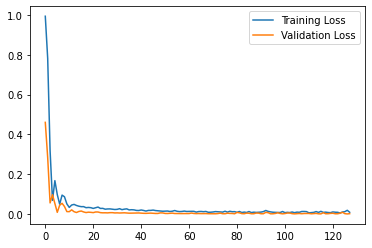

In [263]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

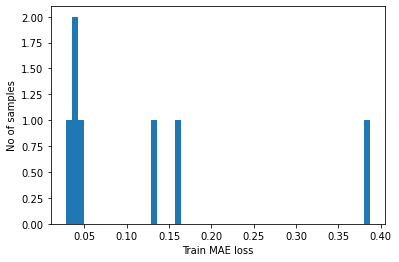

Reconstruction error threshold:  0.38742522545739616


In [264]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

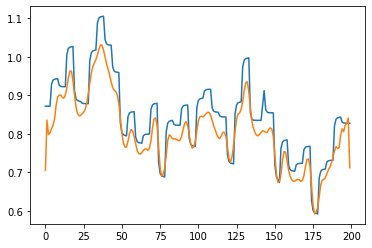

In [265]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [266]:
x_train.shape

(7, 200, 1)

In [268]:
arr=np.array([[1,2],[3,4]])
arr

array([[1, 2],
       [3, 4]])

In [269]:
for x in arr:
    print(x)

[1 2]
[3 4]


In [320]:
await pool.keys("*")

[b'tspj:application_1619800099011_0001',
 b'application_1619800099011_0001',
 b'sequential_jobs:application_1619800099011_0001',
 b'applications',
 b'last_job_score:application_1619800099011_0001']

In [329]:
await pool.srem("tspj:application_1619800099011_0001", *[str(i) for i in range(3932, 4023)])

91

In [317]:
(await pool.info())["memory"]["used_memory_human"]

'36.07M'

In [27]:
from scipy.stats import kstest
from scipy.stats.mstats import chisquare

In [49]:
kstest([0.81, 0.1, 0.2], "uniform")

KstestResult(statistic=0.4666666666666666, pvalue=0.4151111111111112)